# Project Proposal:
## Predicting if a Business is Fraudulent using KNN Classification

### Group 28 Members: Michael Ly, Avery Ma and Veer Arora

Introduction:

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* Clearly state the question you will try to answer with your project
* Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:
* Demonstrate that the dataset can be read from the web into R 
* Clean and wrangle your data into a tidy format
* Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
* Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

Methods:

* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* Describe at least one way that you will visualize the results

Expected outcomes and significance:

* What do you expect to find?
* What impact could such findings have?
* What future questions could this lead to?
       

# Introduction: Fraudulent or Non-Fraudlent?


Our question is if we were given a data set of characteristics of firms of different sectors would we be able to create a classification model that can accurately identify fraudulent firms? Will it be reliable and accurate enough for us to classify whether a firm is fraudulent or legitimate?

Our data set consists of samples of firms across 14 different sectors categorized by Sector ID from 1 to 14.
The sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200).

Our data set is drawn from the UCI Machine Learning Repository, with its origins from Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64. https://archive.ics.uci.edu/ml/datasets/Audit+Data

There are 27 attributes describing the column of data:

After in-depth interview with the auditors, important risk factors are evaluated and their probability of existence is calculated from the present and past records

* Sector Score: Historical risk score value of the target-unit
* Location ID: Unique ID of the city/province.
* Para A value: Discrepancy found in the planned-expenditure of inspection and summary report A in Rs (in crore).
* Para B value: Discrepancy found in the unplanned-expenditure of inspection and summary report B in Rs (in crore).
* Number: Historical discrepancy score.
* Total: Total amount of discrepancy found in other reports Rs (PARA_A + PARA_B).
* Money Value: Amount of money involved in misstatements in the past audits.
* District Loss: Amount of loss suffered by the district
* History: Average historical loss suffered by firm in the last 10 years.
* Inherent_Risk
* Control_Risk
* Detection_Risk
* Audit_Risk 
* Risk

* Loss: Amount of loss suffered by the firm last year.
* District Score: Historical risk score of a district in the last 10 years.
* Sector ID: Unique ID of the target sector.
* ARS: Total risk score using analytical procedure.
* Risk Class: Risk Class assigned to an audit-case. (Target Feature)
* Audit ID: Unique Id assigned to an audit case.

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
target_firms <- read_csv("https://www.tandfonline.com/action/downloadTable?id=T0001&doi=10.1080%2F08839514.2018.1451032&downloadType=CSV")
target_firms

Rows: 14 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Target sector, Information
dbl (2): Sector ID, Number of target firms

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector ID,Target sector,Information,Number of target firms
<dbl>,<chr>,<chr>,<dbl>
1,IR,Irrigation,114
2,P,Public Health,77
3,BR,Buildings and Roads,82
⋮,⋮,⋮,⋮
12,F,Fisheries,41
13,I,Industries,37
14,A,Agriculture,200


* audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc
* To examine the present and historical risk factors for determining the Risk Audit Score for 777 target firms
* evaluating the Risk Audit Class (Fraud and No-Fraud)
* build a classification model that can predict the fraudulent firm on the basis of the present and historical risk factors

In [6]:
audit_risk_data <- read_csv("data/audit_risk.csv")
audit_risk_data <- mutate(audit_risk_data, Risk = as_factor(Risk))
trial_data <- read_csv("data/trial.csv")


New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [73]:
audit_split <- initial_split(audit_risk_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

audit_training_select <- audit_training |> 
    select(Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers, Money_Value, District_Loss,History, Inherent_Risk, CONTROL_RISK, Audit_Risk, Risk) 
audit_training_select

Sector_score,LOCATION_ID,PARA_A,PARA_B,TOTAL,numbers,Money_Value,District_Loss,History,Inherent_Risk,CONTROL_RISK,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0,4.83,4.83,5,0.94,2,0,2.554,0.4,0.5108,0
3.89,6,0,0.08,0.08,5,0.00,2,0,1.416,0.4,0.2832,0
3.89,6,0,0.83,0.83,5,2.95,2,0,2.156,0.4,0.4312,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,12,0.00,11.68,11.68,5,0.00,2,0,8.408,0.4,1.6816,1
55.57,2,1.06,0.63,1.69,5,0.90,6,0,2.930,1.2,1.7580,1
55.57,13,1.06,1.60,2.66,5,16.09,2,0,12.118,0.4,2.4236,1


Risk,n
<fct>,<int>
0,353
1,228


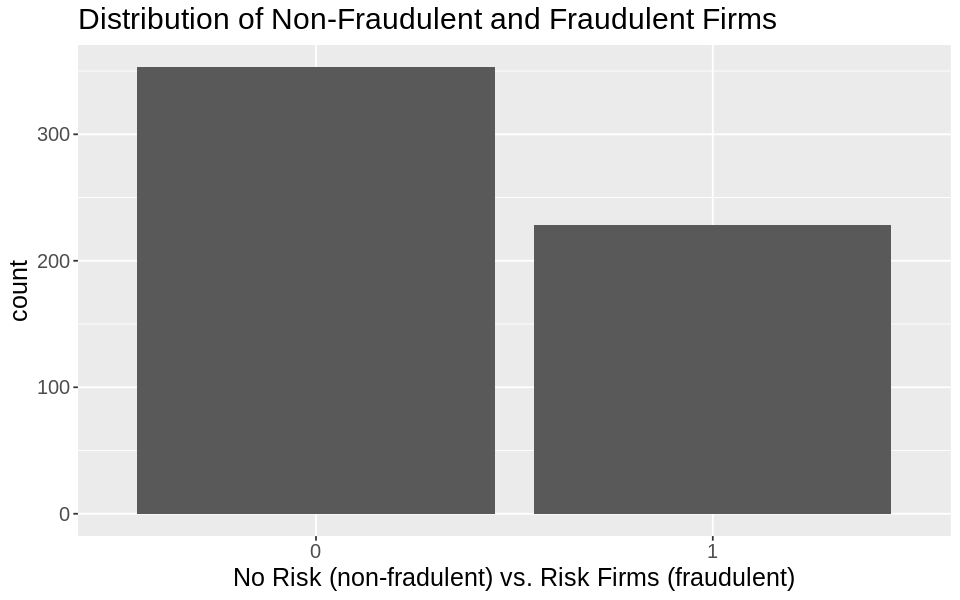

In [87]:
options(repr.plot.width = 8, repr.plot.height = 5)


numbers_plot <- audit_training_select |>
ggplot(aes(x= Risk)) +
geom_bar() + 
    xlab("No Risk (non-fradulent) vs. Risk Firms (fraudulent)") +
    labs() +
    ggtitle("Distribution of Non-Fraudulent and Fraudulent Firms")+
    theme(text = element_text(size = 15))

numbers_plot

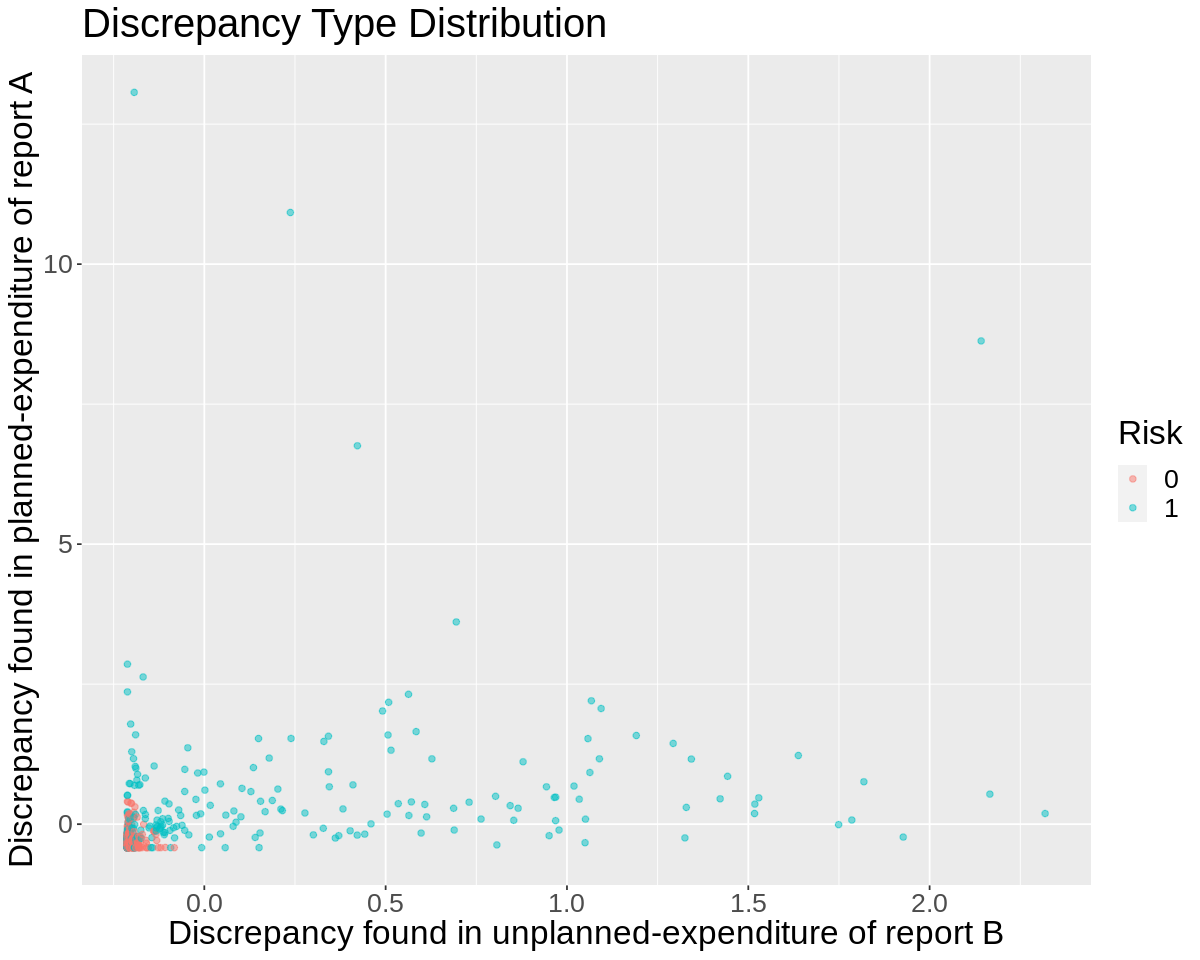

In [119]:
options(repr.plot.width = 10, repr.plot.height = 8)

audit_training_scaled <- audit_training_select |>
        mutate(scaled_money_value = scale(Money_Value, center = TRUE),
               scaled_total = scale(TOTAL, center = TRUE),
              PARA_A_scaled = scale (PARA_A, center = TRUE),
              PARA_B_scaled = scale (PARA_B, center = TRUE))
audit_scaled_filter <- audit_training_scaled |>
    arrange(PARA_B_scaled) |>
    filter(PARA_B_scaled < 20)
## filter out of major outliers to create better visualization



discrepancy_plot <- audit_scaled_filter |>
ggplot(aes(x = PARA_B_scaled, y = PARA_A_scaled, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Discrepancy found in unplanned-expenditure of report B") +
    ylab("Discrepancy found in planned-expenditure of report A") +
    labs(color = "Risk") +
    ggtitle("Discrepancy Type Distribution") +
    theme(text = element_text(size = 20))

discrepancy_plot

Warning message:
“Removed 1 rows containing missing values (geom_point).”


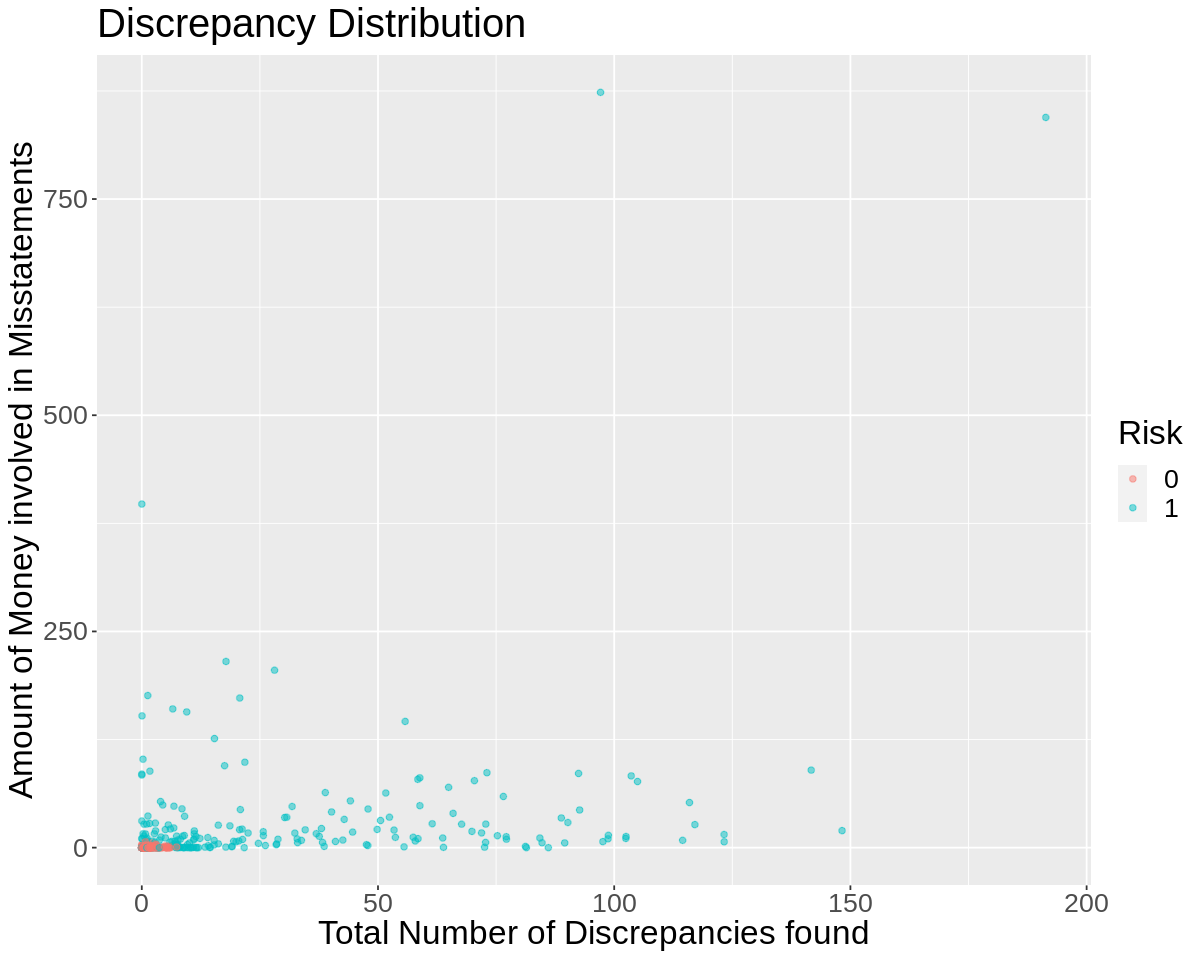

In [134]:
options(repr.plot.width = 10, repr.plot.height = 8)
money_value_plot <- audit_scaled_filter |>
ggplot(aes(x = TOTAL, y = Money_Value, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Total Number of Discrepancies found") +
    ylab("Amount of Money involved in Misstatements") +
    labs(color = "Risk") +
    ggtitle("Discrepancy Distribution") +
    theme(text = element_text(size = 20))

money_value_plot

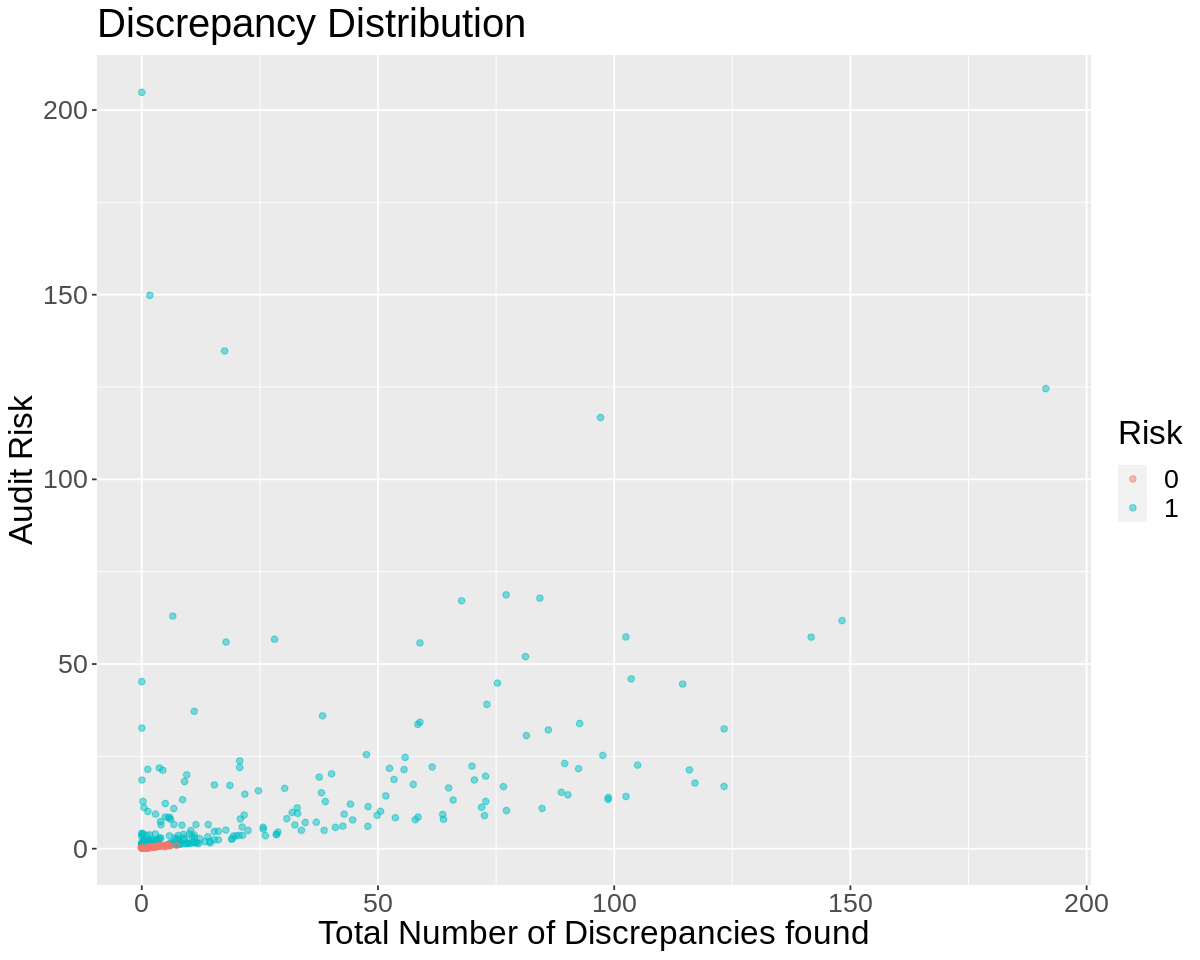

In [131]:
options(repr.plot.width = 10, repr.plot.height = 8)
money_value_plot <- audit_scaled_filter |>
ggplot(aes(x = TOTAL, y = Audit_Risk, color = Risk)) +
geom_point(alpha = 0.5) +
    xlab("Total Number of Discrepancies found") +
    ylab("Audit_") +
    labs(color = "Risk") +
    ggtitle("Discrepancy Distribution") +
    theme(text = element_text(size = 20))

money_value_plot

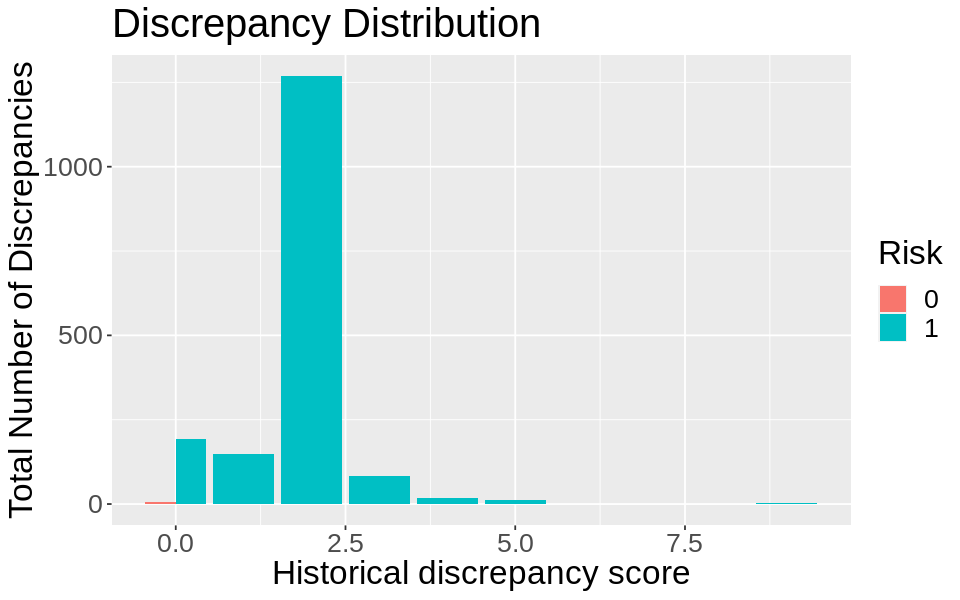

In [130]:
options(repr.plot.width = 8, repr.plot.height = 5)


PARA_A_plot <- audit_training_scaled |>
ggplot(aes(x= History, y= TOTAL, fill = Risk)) +
geom_bar(stat = "identity", position = "dodge") + 
    xlab("Historical discrepancy score") +
    ylab("Total Number of Discrepancies") +
    labs(fill = "Risk") +
    ggtitle("Discrepancy Distribution")+
    theme(text = element_text(size = 20))

PARA_A_plot

Risk,TOTAL,n
<fct>,<dbl>,<int>
0,0.000,49
0,0.017,1
0,0.030,3
⋮,⋮,⋮
1,148.23,1
1,191.36,1
1,1268.91,1


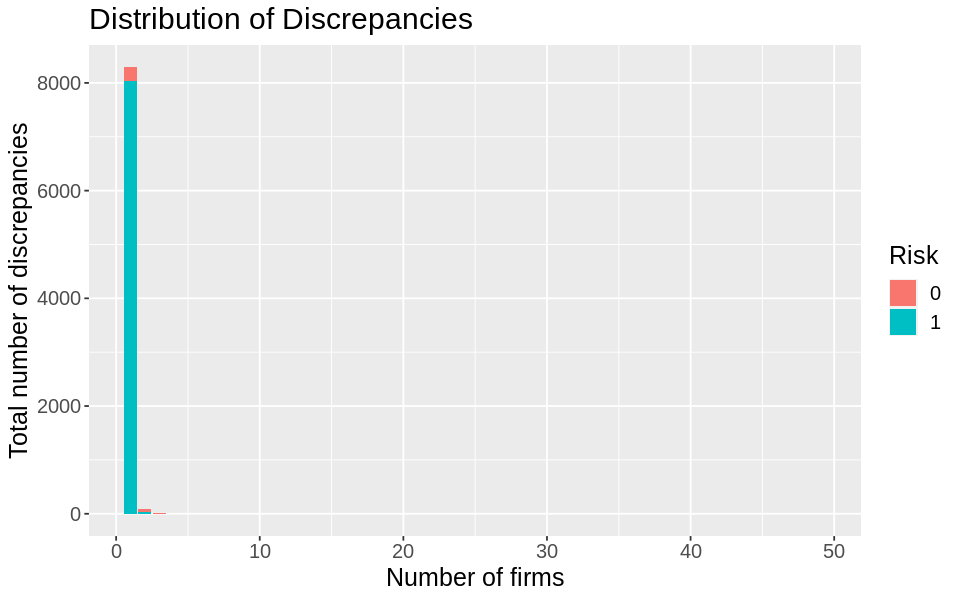

In [124]:
options(repr.plot.width = 8, repr.plot.height = 5)

numbers <- count(audit_training_select, Risk, TOTAL)
numbers
# numbers <- count(audit_training_select, Risk, numbers)

total_plot <- numbers |>
ggplot(aes(x= n, y = TOTAL, fill = Risk)) +
geom_bar(stat = "identity") + 
    xlab("Number of firms") +
    ylab("Total number of discrepancies") +
    ggtitle("Distribution of Discrepancies")+
    theme(text = element_text(size = 15))

total_plot

Risk,TOTAL,n
<fct>,<dbl>,<int>
0,0.017,1
0,0.030,3
0,0.040,1
⋮,⋮,⋮
1,148.23,1
1,191.36,1
1,1268.91,1


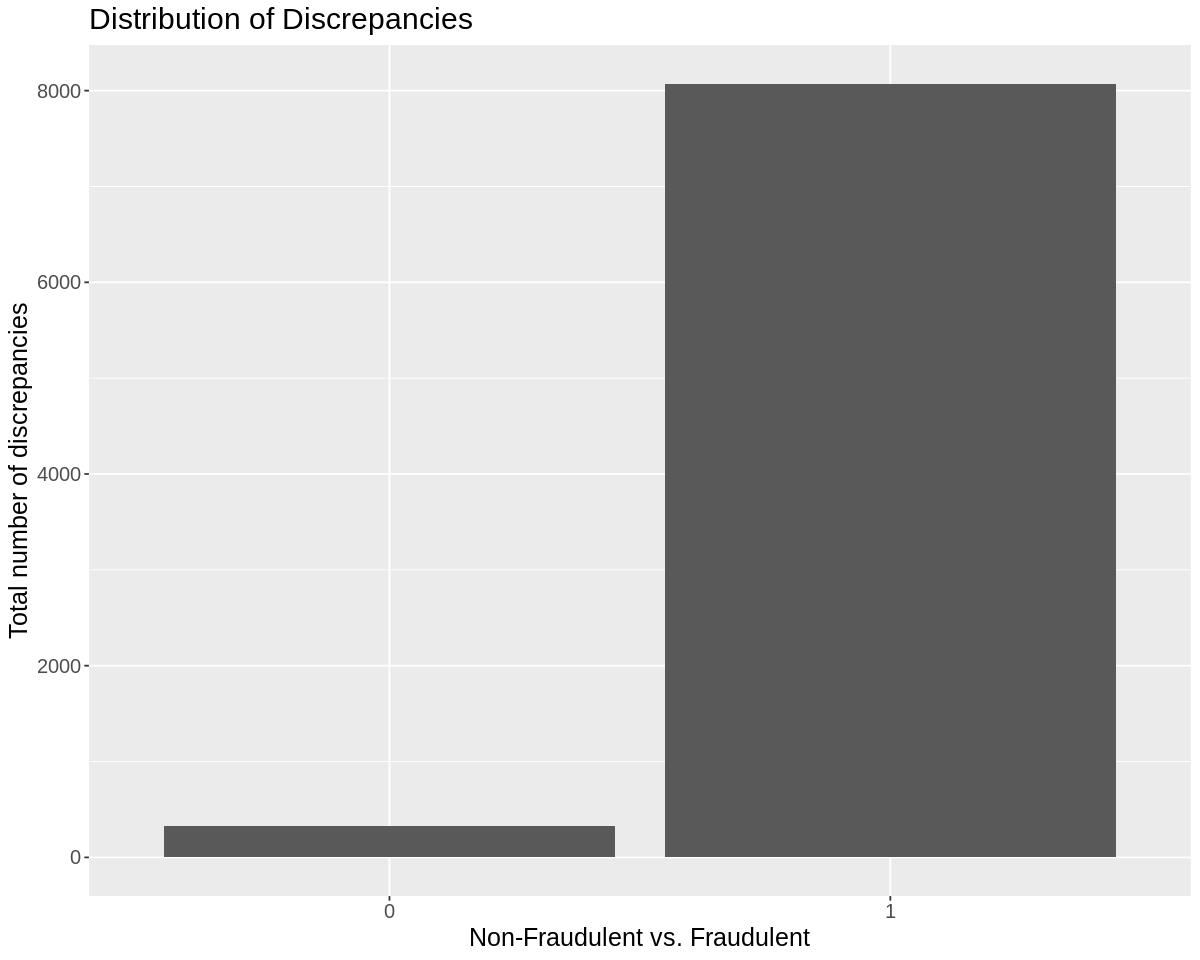

In [129]:
numbers_filtered <- count(audit_training_select, Risk, TOTAL)|> 
    filter(n < 8)
numbers_filtered
# numbers <- count(audit_training_select, Risk, numbers)

total_plot <- numbers_filtered |>
ggplot(aes(x= Risk, y = TOTAL)) +
geom_bar(stat = "identity") + 
    xlab("Non-Fraudulent vs. Fraudulent") +
    ylab("Total number of discrepancies") +
    ggtitle("Distribution of Discrepancies")+
    theme(text = element_text(size = 15))

total_plot

In [128]:
risk <- audit_training |> 
    filter(Risk == 1)
no_risk <- audit_training |>
    filter(Risk == 0)
nrow(risk)
nrow(no_risk)


[1] 228

[1] 353